# Vector Rayleigh-Sommerfeld method (VRS)


In [1]:
from diffractio import np, sp, plt, nm, um, mm, degrees
from matplotlib import cm

from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.vector_fields_XY import Vector_field_XY

## Radial polarized Gaussian beam through a circular aperture


In [2]:
size = 6.4 * um
x0 = np.linspace(-size, size, 512)
y0 = np.linspace(-size, size, 512)


In [3]:
wavelength = .640 * um

radius = 10 * wavelength / 2
z_obs = 10 * um
beam_width = 6 * um / (2 * np.sqrt(2))


In [4]:
u0 = Scalar_source_XY(x0, y0, wavelength)
u0.gauss_beam(A=1, r0=(0, 0), z0=0, w0=beam_width)

t0 = Scalar_mask_XY(x0, y0, wavelength)
t0.circle(r0=(0, 0), radius=radius)

t = u0 * t0


In [5]:
E0 = Vector_source_XY(x0, y0, wavelength)
E0.radial_wave(u=t, r0=(0, 0))


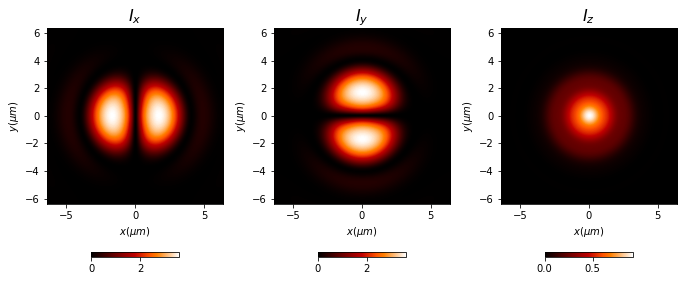

In [6]:
E1 = E0.VRS(z=z_obs, n=1, new_field=True)
E1.draw('intensities', logarithm=1e2)


## Focusing with a lens a beam with a high $E_z$ component
In Figures 4 and 5 a planar lens formed by rings is developed in order to obtain a high $E_z$ component. The data of the radii are shown in Table 1.

In [7]:
size = 30 * um
x0 = np.linspace(-size, size, 1024)
y0 = np.linspace(-size, size, 1024)


In [8]:
wavelength = .6328 * um
focal = 10 * um


In [9]:
u0 = Scalar_source_XY(x0, y0, wavelength)
u0.plane_wave(A=1)

t0 = Scalar_mask_XY(x0, y0, wavelength)
t0.lens(r0=(0, 0), focal=focal, radius=20 * um)

t1 = u0 * t0


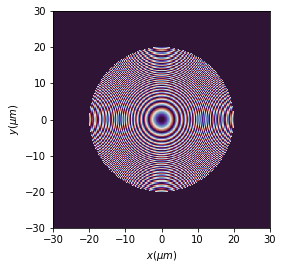

In [10]:
t0.draw('phase')


In [11]:
E0 = Vector_source_XY(x0, y0, wavelength)
E0.radial_wave(u=t1, r0=(0, 0))


In [12]:
%%time
E1=E0.VRS(z=z_obs, n=1, new_field=True)
E1.cut_resample([-3, 3], [-3, 3], num_points=[512, 512])


CPU times: user 7.06 s, sys: 405 ms, total: 7.47 s
Wall time: 7.47 s


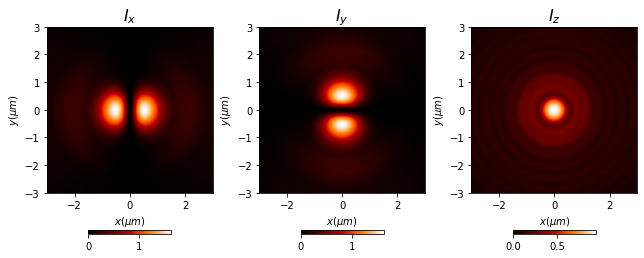

In [13]:
E1.draw('intensities', logarithm=1e-1)

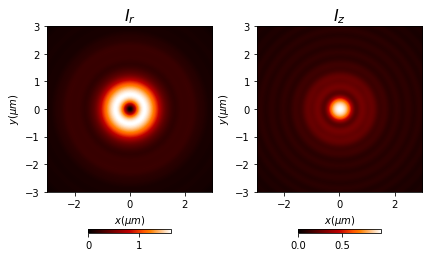

In [14]:
E1.draw('intensities_rz', logarithm=1e-1)

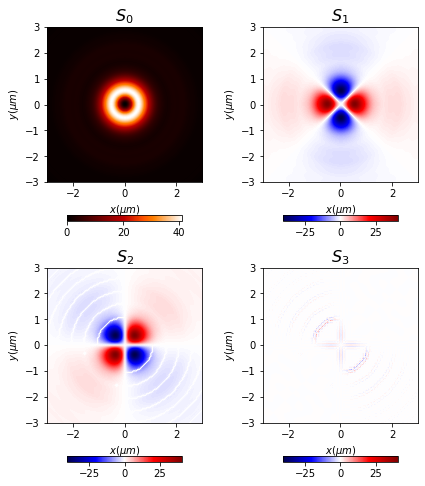

In [15]:
E1.draw('stokes')